In [0]:
!wget ''
!unzip 

http://: Invalid host name.
UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  test compressed archive data
  -u  update files, create if necessary      -z  display archive comment only
  -v  list verbosely/show version info       -T  timestamp archive to latest
  -x  exclude files that follow (in xlist)   -d  extract files into exdir
modifiers:
  -n  never overwrite existing files         -q  quiet mode (-qq => quieter)
  -o  overwrite files WITHOUT prompting      -a  auto-convert any text files
  -j  junk paths (do not make directories)   -aa treat ALL files as text
  -U  use escapes for all non-ASCII Unicode  -UU ignore 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd


In [0]:
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train_masks.csv')
df.shape

(5088, 2)

In [0]:
train_df = df[:4000]
val_df = df[4000:]

In [0]:
df[:5]

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [0]:
!unzip -q /content/gdrive/My\ Drive/train.zip -d train

In [0]:
img_name, mask_rle = train_df.iloc[4]

img = cv2.imread('train/train/{}'.format(img_name))
mask = rle_decode(mask_rle)

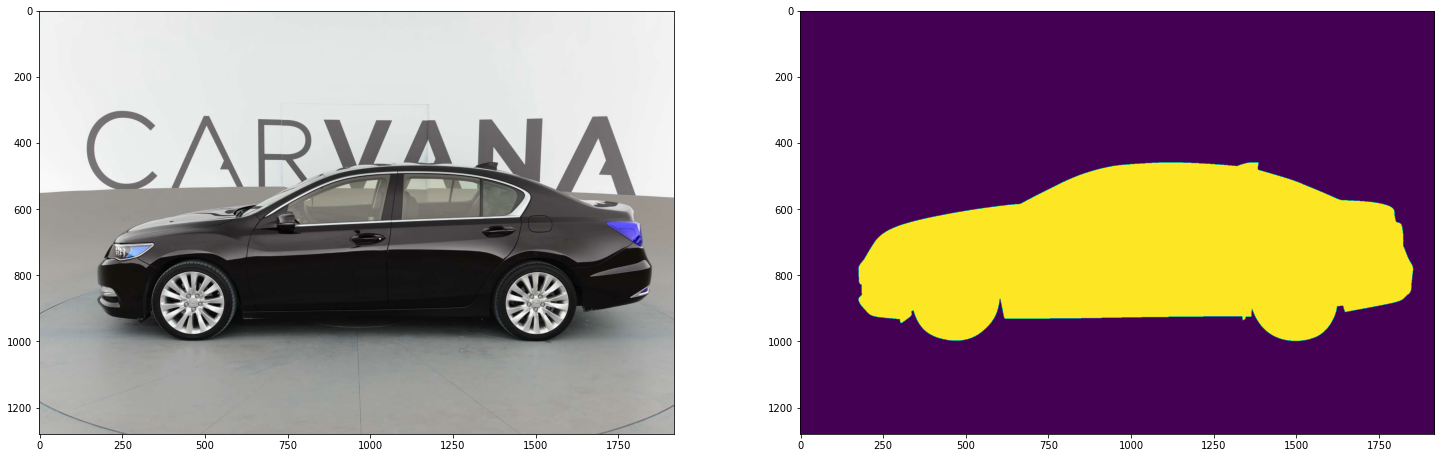

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(img)
axes[1].imshow(mask[..., 0])

plt.show()

In [0]:
def keras_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread('train/train/{}'.format(img_name))
            mask = rle_decode(mask_rle)
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [0]:
for x, y in keras_generator(train_df, 16):
    break

In [0]:
x.shape

(16, 256, 256, 3)

In [0]:
y.shape


(16, 256, 256, 1)

## Layer examples

In [0]:
UpSampling2D(size=(32, 32), interpolation='bilinear')(layer)
Conv2D(1, (1,1), strides=(1, 1))(layer)
Conv2D(256, (3,3), padding='same')(layer)
Activation('relu')(layer)
Concatenate(axis=-1)([layer_1, layer_2])


NameError: ignored

# FCN

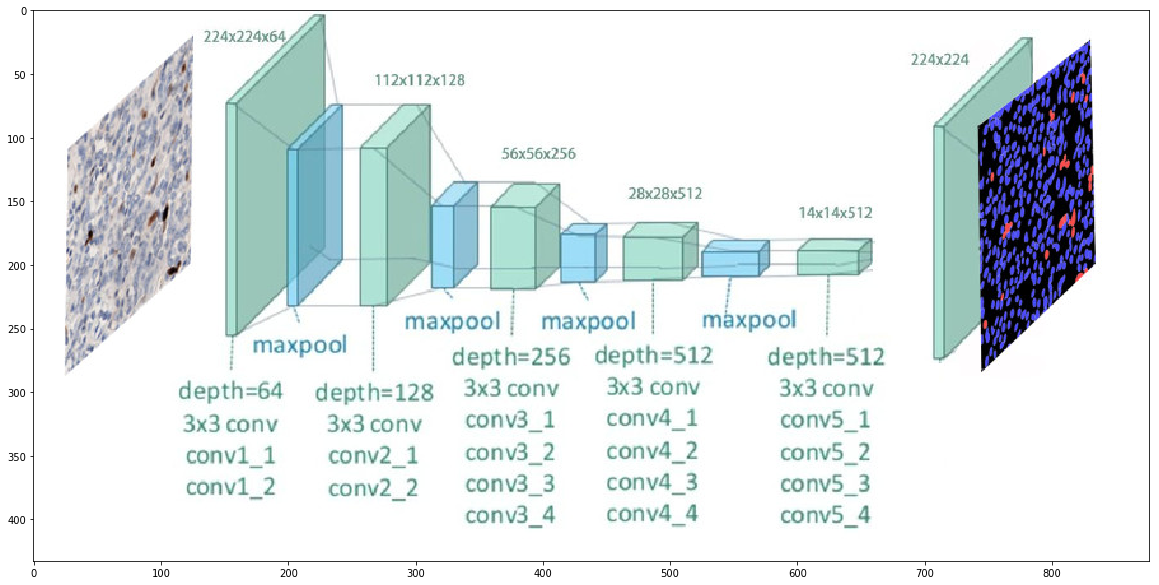

In [0]:
fcn_png = cv2.imread('fcn.jpg')
plt.figure(figsize=(20,20))
plt.imshow(fcn_png[..., [2,1,0]])
plt.show()

In [0]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation


base_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)


base_out = base_model.output


up = UpSampling2D(32, interpolation='bilinear')(base_out)
conv = Conv2D(1, (1, 1))(up)
conv = Activation('sigmoid')(conv)

model = Model(input=base_model.input, output=conv)

Using TensorFlow backend.


58892288/58889256 [==============================] - 2s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


In [0]:
up

<tf.Tensor 'up_sampling2d_1/ResizeBilinear:0' shape=(None, 256, 256, 512) dtype=float32>

In [0]:
base_out

<tf.Tensor 'block5_pool/MaxPool:0' shape=(None, 8, 8, 512) dtype=float32>

In [0]:
256/8

32.0

In [0]:
pred = model.predict(x)

In [0]:
pred.shape

(16, 256, 256, 1)

In [0]:
cv2.resize(pred[0, :, :, 2], (256, 256)).shape

IndexError: ignored

In [0]:
best_w = keras.callbacks.ModelCheckpoint('fcn_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('fcn_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [0]:
batch_size = 16
model.fit_generator(keras_generator(train_df, batch_size),
              steps_per_epoch=100,
              epochs=3,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/3
100/100 [==============================] - 126s 1s/step - loss: 0.0755 - val_loss: 0.0397
Epoch 2/3
100/100 [==============================] - 121s 1s/step - loss: 0.0357 - val_loss: 0.0306
Epoch 3/3
100/100 [==============================] - 121s 1s/step - loss: 0.0316 - val_loss: 0.0289


In [0]:
pred = model.predict(x)#.shape


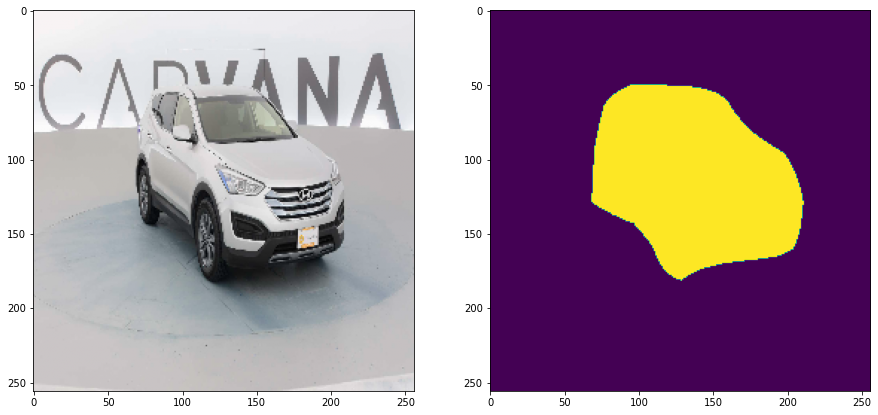

In [0]:

im_id = 0
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

# SegNet

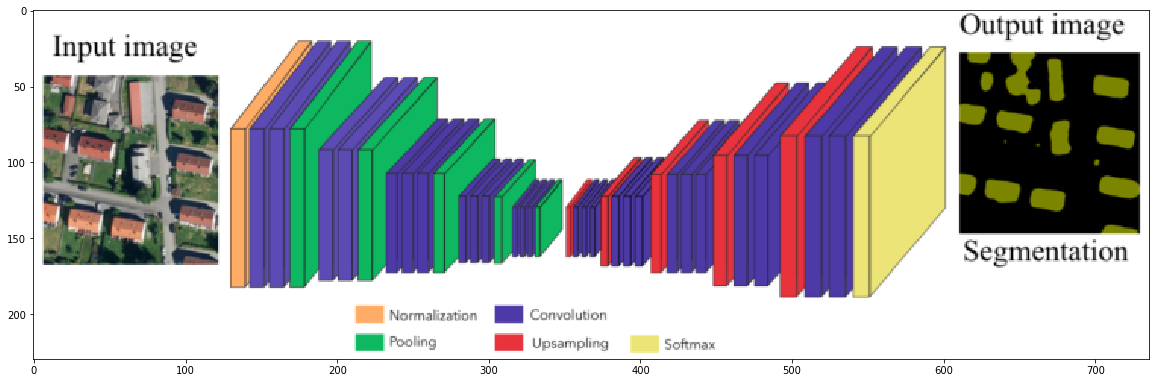

In [0]:
seg_png = cv2.imread('segnet.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

In [0]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D

inp = Input(shape=(256, 256, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)


conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)


conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)


conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)

up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(up_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)


up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(up_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)


up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(up_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)



up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(up_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)
result = Activation('sigmoid')(conv_up_4_2)


model = Model(inputs=inp, outputs=result)

In [0]:
conv_up_4_1

<tf.Tensor 'activation_108/Relu:0' shape=(?, 256, 256, 32) dtype=float32>

In [0]:
conv_1_1

<tf.Tensor 'activation_94/Relu:0' shape=(?, 256, 256, 32) dtype=float32>

In [0]:
best_w = keras.callbacks.ModelCheckpoint('segnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('segnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [0]:
batch_size = 16
model.fit_generator(keras_generator(train_df, batch_size),
              steps_per_epoch=100,
              epochs=15,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/15
100/100 [==============================] - 93s 928ms/step - loss: 0.3188 - val_loss: 0.1345
Epoch 2/15
100/100 [==============================] - 85s 855ms/step - loss: 0.0864 - val_loss: 0.0854
Epoch 3/15
100/100 [==============================] - 85s 848ms/step - loss: 0.0599 - val_loss: 0.0492
Epoch 4/15
100/100 [==============================] - 86s 857ms/step - loss: 0.0394 - val_loss: 0.0416
Epoch 5/15
100/100 [==============================] - 85s 854ms/step - loss: 0.0319 - val_loss: 0.0339
Epoch 6/15
100/100 [==============================] - 84s 844ms/step - loss: 0.0286 - val_loss: 0.0258
Epoch 7/15
100/100 [==============================] - 85s 852ms/step - loss: 0.0267 - val_loss: 0.0242
Epoch 8/15
100/100 [==============================] - 85s 853ms/step - loss: 0.0241 - val_loss: 0.0227
Epoch 9/15
100/100 [==============================] - 86s 860ms/step - loss: 0.0233 - val_loss: 0.0232
Epoch 10/15
100/100 [==============================] - 86s 856ms/step - l

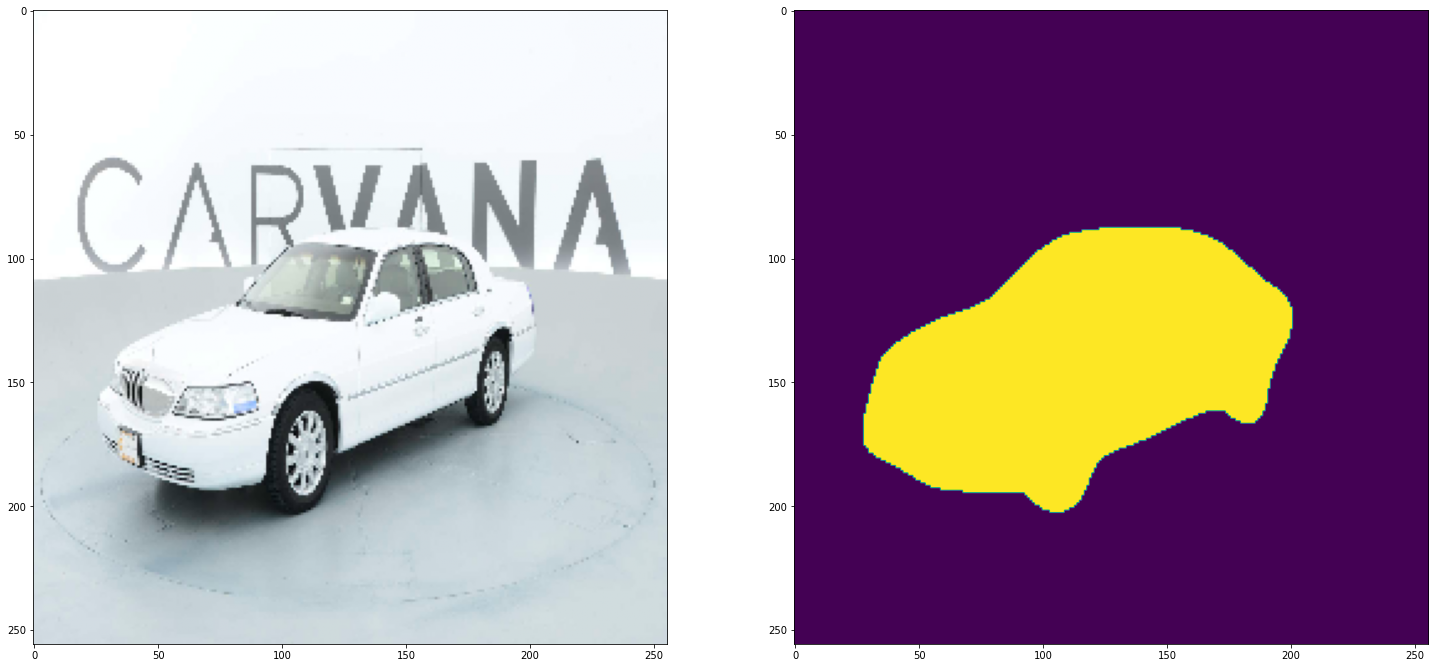

In [0]:
pred = model.predict(x)#.shape

im_id = 14
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

# Vanilla Unet

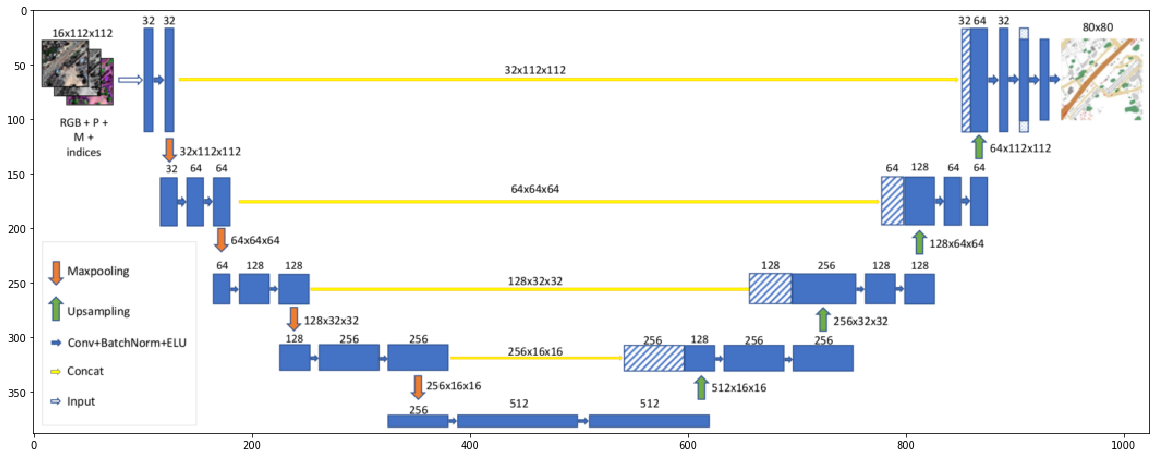

In [0]:
seg_png = cv2.imread('unet.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

In [0]:
pool_4, up_1

(<tf.Tensor 'max_pooling2d_39/MaxPool:0' shape=(?, 16, 16, 256) dtype=float32>,
 <tf.Tensor 'up_sampling2d_24/ResizeBilinear:0' shape=(?, 32, 32, 256) dtype=float32>)

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D

inp = Input(shape=(256, 256, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)


conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)


conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)


conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)

up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conc_1 = Concatenate()([conv_4_2, up_1])

conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)


up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_3_2, up_2])

conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)


up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_2_2, up_3])

conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)



up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([conv_1_2, up_4])
conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)
result = Activation('sigmoid')(conv_up_4_2)


model = Model(inputs=inp, outputs=result)

In [0]:
best_w = keras.callbacks.ModelCheckpoint('unet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('unet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [0]:
batch_size = 16
model.fit_generator(keras_generator(train_df, batch_size),
              steps_per_epoch=100,
              epochs=100,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/100
100/100 [==============================] - 98s 982ms/step - loss: 0.3528 - val_loss: 0.1186
Epoch 2/100
100/100 [==============================] - 91s 912ms/step - loss: 0.0943 - val_loss: 0.0901
Epoch 3/100
100/100 [==============================] - 90s 902ms/step - loss: 0.0679 - val_loss: 0.0689
Epoch 4/100
100/100 [==============================] - 90s 898ms/step - loss: 0.0442 - val_loss: 0.0424
Epoch 5/100
100/100 [==============================] - 90s 901ms/step - loss: 0.0343 - val_loss: 0.0291
Epoch 6/100
100/100 [==============================] - 90s 897ms/step - loss: 0.0303 - val_loss: 0.0420
Epoch 7/100
100/100 [==============================] - 89s 888ms/step - loss: 0.0263 - val_loss: 0.0292
Epoch 8/100
100/100 [==============================] - 89s 891ms/step - loss: 0.0242 - val_loss: 0.0216
Epoch 9/100
100/100 [==============================] - 90s 900ms/step - loss: 0.0216 - val_loss: 0.0177
Epoch 10/100
100/100 [==============================] - 92s 916m

KeyboardInterrupt: ignored

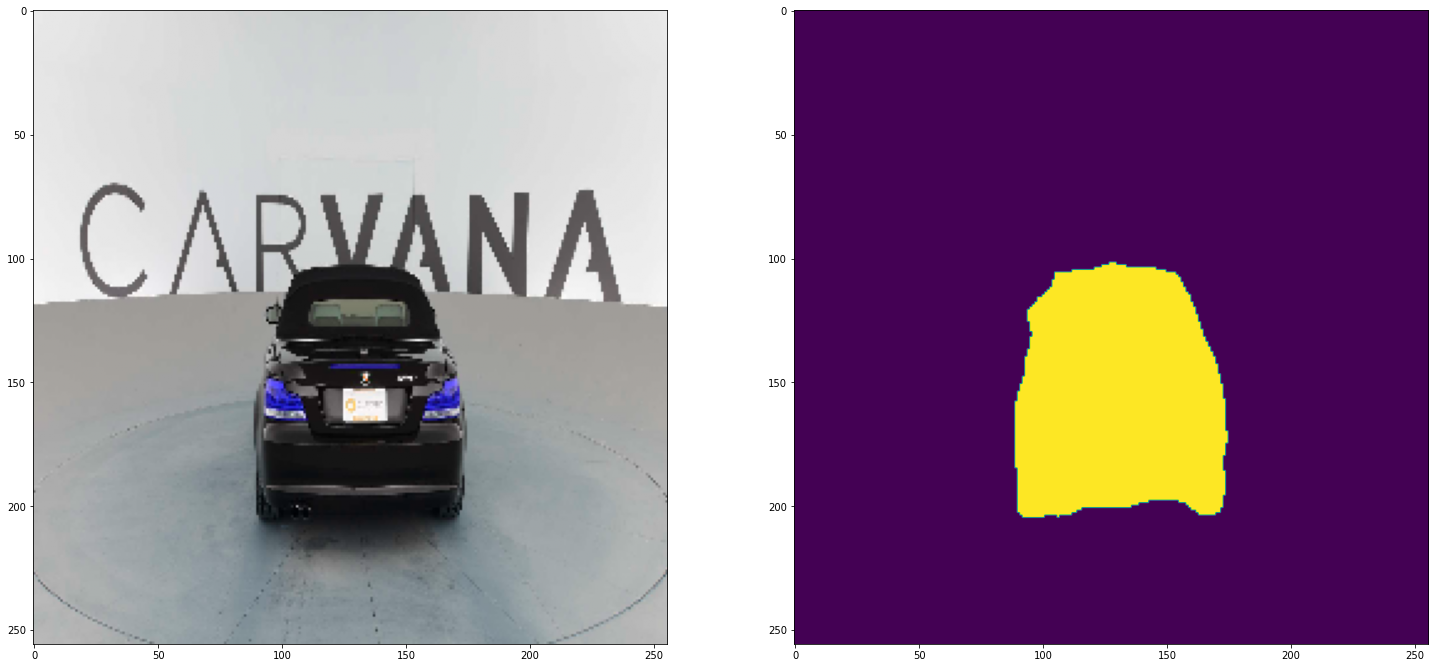

In [0]:
pred = model.predict(x)#.shape

im_id = 7
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

# Unet with ResNet34 encoder

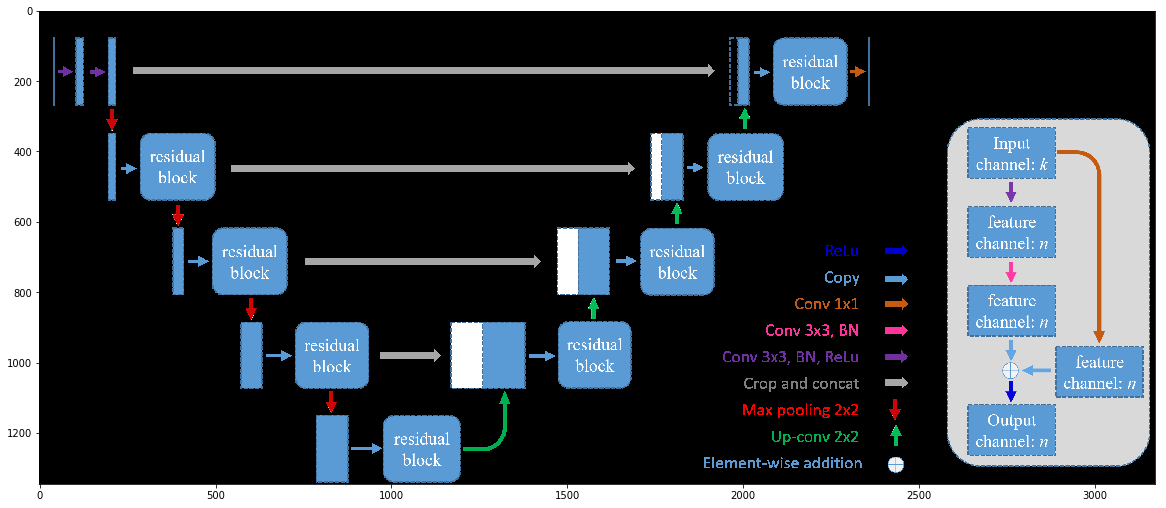

In [0]:
seg_png = cv2.imread('unet_resnet_strucutre_new.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

In [0]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Concatenate, Activation
from keras import backend as K

# create the base pre-trained model
base_model = ResNet50(weights='imagenet', input_shape=(256,256,3), include_top=False)
 
base_out = base_model.output

# up = UpSampling2D(size=(32, 32), data_format=None, interpolation='bilinear')(base_out)
# up = Conv2D(1, (1,1), strides=(1, 1))(up)


# model = Model(input=base_model.input, output=up)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 4s 0us/step


In [0]:
base_out

<tf.Tensor 'activation_82/Relu:0' shape=(None, 8, 8, 2048) dtype=float32>

In [0]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
conv1 = base_model.get_layer('activation_34').output
conv2 = base_model.get_layer('activation_37').output
conv3 = base_model.get_layer('activation_53').output
conv4 = base_model.get_layer('activation_66').output
conv5 = base_model.get_layer('activation_77').output


## CODE

inp = base_model.get_layer('input_4').output

In [0]:
conv1

<tf.Tensor 'activation_34/Relu:0' shape=(None, 128, 128, 64) dtype=float32>

In [0]:
conv2

<tf.Tensor 'activation_37/Relu:0' shape=(None, 64, 64, 256) dtype=float32>

In [0]:
conv3

<tf.Tensor 'activation_53/Relu:0' shape=(None, 32, 32, 128) dtype=float32>

In [0]:
conv4

<tf.Tensor 'activation_66/Relu:0' shape=(None, 16, 16, 256) dtype=float32>

In [0]:
conv5

<tf.Tensor 'activation_77/Relu:0' shape=(None, 8, 8, 512) dtype=float32>

In [0]:
up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
conc_1 = Concatenate()([up1, conv4])
conv_conc_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_conc_1 = Activation('relu')(conv_conc_1)

up2 = UpSampling2D(2, interpolation='bilinear')(conv_conc_1)
conc_2 = Concatenate()([up2, conv3])
conv_conc_2 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_conc_2 = Activation('relu')(conv_conc_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_conc_2)
conc_3 = Concatenate()([up3, conv2])
conv_conc_3 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_conc_3 = Activation('relu')(conv_conc_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv1])
conv_conc_4 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_conc_4 = Activation('relu')(conv_conc_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conv_conc_5 = Conv2D(3, (3, 3), padding='same')(up5) #или (1,(3,3)) для одного класса. а у нас для 3
conv_conc_5 = Activation('softmax')(conv_conc_5) #или активация('sigmoid') для одного класса. а у нас для 3


In [0]:
conv_conc_4

<tf.Tensor 'activation_86/Relu:0' shape=(None, 128, 128, 32) dtype=float32>

In [0]:
model = Model(input=base_model.input, output=conv_conc_5)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [0]:
best_w = keras.callbacks.ModelCheckpoint('resnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('resnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [0]:
batch_size = 16
model.fit_generator(keras_generator(train_df, batch_size),
              steps_per_epoch=100,
              epochs=100,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/100
100/100 [==============================] - 97s 973ms/step - loss: 0.0478 - val_loss: 0.0153
Epoch 2/100
100/100 [==============================] - 91s 910ms/step - loss: 0.0152 - val_loss: 0.0135
Epoch 3/100
100/100 [==============================] - 90s 902ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 4/100
100/100 [==============================] - 91s 910ms/step - loss: 0.0131 - val_loss: 0.0193
Epoch 5/100
100/100 [==============================] - 91s 911ms/step - loss: 0.0125 - val_loss: 0.0170
Epoch 6/100
100/100 [==============================] - 90s 904ms/step - loss: 0.0124 - val_loss: 0.0132
Epoch 7/100
100/100 [==============================] - 91s 908ms/step - loss: 0.0118 - val_loss: 0.0142
Epoch 8/100
100/100 [==============================] - 91s 905ms/step - loss: 0.0115 - val_loss: 0.0122
Epoch 9/100
 56/100 [===============>..............] - ETA: 28s - loss: 0.0114

KeyboardInterrupt: ignored

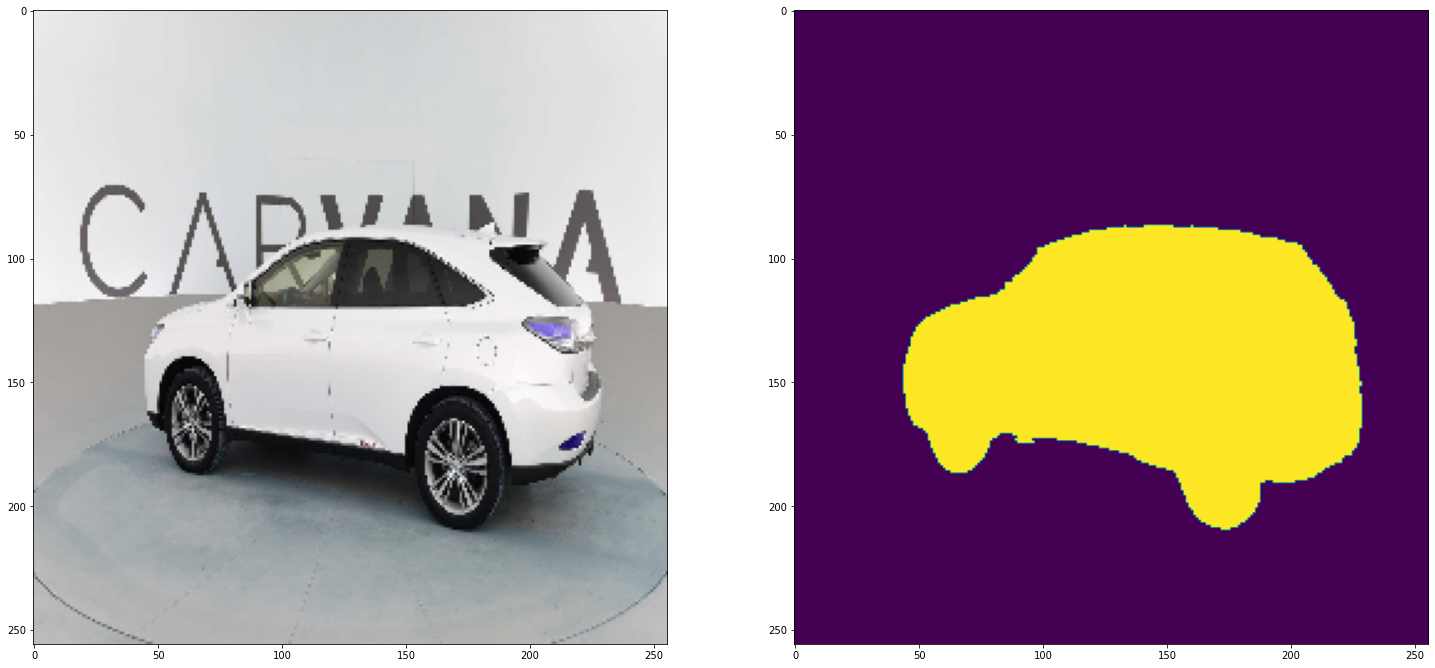

In [0]:
pred = model.predict(x)#.shape

im_id = 3
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] >0.5)

plt.show()

In [0]:
https://github.com/qubvel/segmentation_models

# Аугментации

In [0]:
from albumentations import (
    CLAHE, RandomRotate90, Transpose, RandomCrop, Resize, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, HorizontalFlip, OneOf, Compose, PadIfNeeded, LongestMaxSize, PadIfNeeded, ElasticTransform,Cutout
)




def strong_aug(p=1.0):
    return Compose([
        ShiftScaleRotate(shift_limit=0.125, scale_limit=0.2, rotate_limit=10, p=0.7, border_mode=cv2.BORDER_CONSTANT),
        RandomCrop(256, 256),
        #PadIfNeeded(min_height=224, min_width=224, border_mode=cv2.BORDER_CONSTANT, p=1.0),
        #Resize(64, 64),
        #RandomRotate90(),
        ElasticTransform(1.), 
        #HorizontalFlip(),
        #Cutout(p=1.),
        #Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.3),
        OneOf([
            MotionBlur(p=.4),
            MedianBlur(blur_limit=3, p=0.3),
            Blur(blur_limit=3, p=0.3),
        ], p=0.5),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.5),
        OneOf([
            CLAHE(clip_limit=3),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.4),
        HueSaturationValue(p=0.7),
         
        
        
    ],
        p=p)

In [0]:
img = cv2.imread('prepod.jpg')
mask = cv2.imread('prepod_mak.jpg')

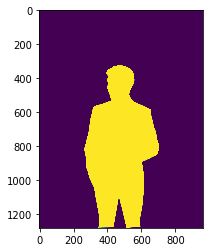

In [0]:
plt.imshow(mask[..., 0])

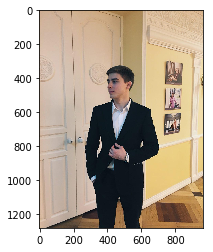

In [0]:
plt.imshow(img[..., [2,1,0]])

In [0]:
img.shape

(500, 500, 3)

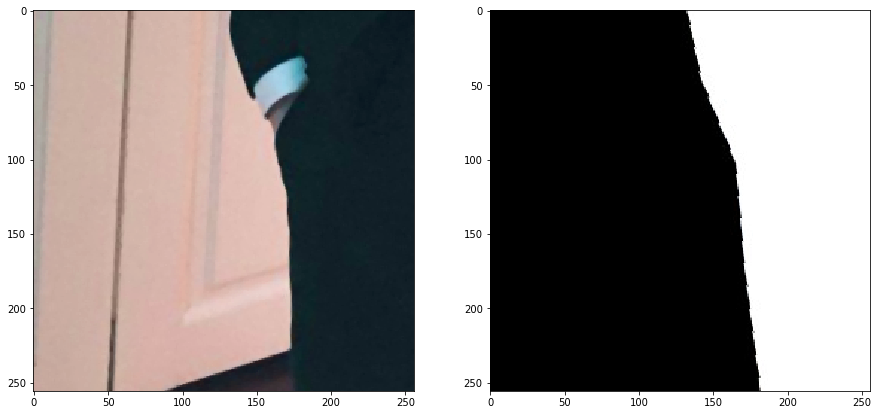

In [0]:
augmentation = strong_aug(p=1.0)


data = {'image': img.astype('uint8'), 'mask': mask}
augmented = augmentation(**data)
crop_img, crop_mask = augmented["image"], augmented["mask"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(crop_img[..., [2,1,0]])
axes[1].imshow(crop_mask)

plt.show()